# Topic Modeling with Jira stories


Firstly, we need to import all the necessary packages and create our dataframe. Please ensure to update the path with the correct folder location on your local machine.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import spacy
import nltk
import re
import string
import pandas as pd
import numpy as np

from stop_word_list import *
from cleanText import *
import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
# %matplotlib inline

# Load the data
import os

folder_path = 'C:/Users/SEPA/topic_modeling/Tech_data/ChatGPT_jira_stories'  # Replace with the path to your folder
file_list = []

# Iterate over each file in the folder and append its content
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)

        # Open the file and read its contents
        with open(file_path, 'r') as file:
            content = file.read()
            file_list.append(content)

# create own examples for each Jira story (each new Title)
all_files = []
for file in file_list:
    all_files += file.split('Title')
    
# build a data frame with this
df = pd.DataFrame(all_files)
df = df.rename(columns={0: 'skill_description'})
df = df[df['skill_description'] != '']

print(len(df))

494


We have a total of 494 examples, such as Jira stories, to use for training our model. In the subsequent step, we will perform data cleaning by converting all characters to lowercase. Furthermore, we will remove newline characters and punctuations (e.g., .,/) from the text. Additionally, we will apply word lemmatization, which converts words like "running" or "ran" to their base form, such as "run".

In [2]:
for index, row in df.iterrows():
    # print(df.iloc[index,0])
    row['skill_description'] = row['skill_description'].replace("\n", " ")
    row['skill_description'] = row['skill_description'].replace("Description:", "")

clean_df = clean_all(df, 'skill_description')
print(clean_df.iloc[0][0])

provision aws ec instance for application deployment as a devop engineer I need to provision aws ec instance to host our application ensure scalability high availability and efficient resource allocation this task involve select appropriate instance type configure security group and network setting and set up auto scale policy to handle vary application workload


Next, we will proceed with generating meaningful bigrams and trigrams, a crucial step considering that skills are often represented by combinations of words. By creating bigrams, we can treat terms like "neural networks" and "machine learning" as single entities. Additionally, we will eliminate stopwords from the data, as they are generally considered irrelevant for skill representation. Stopwords include common words like "the," "is," and "and."

In [3]:
# bigram_scores
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split() for comment in clean_df.skill_description])
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

# trigram_scores
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split() for comment in clean_df.skill_description])
finder.apply_freq_filter(20)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram: \
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]
# examples of bigrams
print(bigrams[:10])

def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

reviews_w_ngrams = clean_df.copy()
reviews_w_ngrams.skill_description = reviews_w_ngrams.skill_description.map(lambda x: replace_ngram(x))
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.skill_description.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in english_names\
                                                              and len(word) > 2])

['power bi', 'natural language', 'time series', 'real time', 'scikit learn', 'neural network', 'google cloud', 'anomaly detection', 'apache kafka', 'language processing']


Our algorithm has effectively identified relevant bigrams, such as "apache kafka" and "neural network," which represent specific skills. To further enhance the accuracy of skill representation, we will now exclude adjectives and verbs, focusing specifically on nouns, which are better suited for capturing skill entities.

In [5]:
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered
final_reviews = reviews_w_ngrams.map(noun_only)

dictionary = corpora.Dictionary(final_reviews)

# each element of  the vector represents a unique word in the dictionary and its corresponding frequency in the document.
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

Prior to training our final model, it is crucial to optimize the number of topics based on the coherence score, which measures the degree of semantic similarity between words within a topic, indicating how coherent and distinct the topics are .Since we need to predefine the number of topics, we will iterate through a range of 5 to 25 topics and assess the coherence score for each iteration.

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24


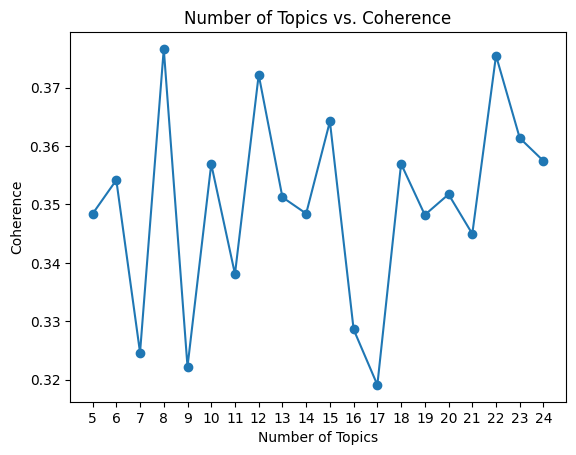

In [5]:
# To decide the number of topics we will maximize the coherence.
# For this we will iterate over 5 up to 25 topics and calculate for each model the coherence
coherence = []
for k in range(5, 25):
    print('Round: ' + str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word=dictionary, passes=40, \
                   iterations=200, chunksize=10000, eval_every=None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews, \
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k, cm.get_coherence()))


# evaluiere coherence
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

Now, we are ready to train our LDA model, which will perform topic modeling and generate visualizations of the identified topics. The competence clusters are represented as word clouds, where the frequency of keywords corresponds to the size of the cloud and thus to the importance within the cluster. From the plot one can also understand the dependencies between the competence clusters by checking the overlap between them.
To enhance topic interpretability and focus on topic-specific terms rather than globally common terms (e.g., "model"), I suggest adjusting the relevance metric to 0.2. This adjustment reduces the weight of frequently occurring terms across all documents.

In word cloud one, we observe terms like "neural network," "text classification," and "cnn," suggesting a topic centered around Deep Learning. On the other hand, topic 2 appears to revolve around data preprocessing, with frequent terms such as "spark," "apache_kafka," and "warehouse." Topics 4 and 6 exhibit similarities and seem to pertain to cloud-related subjects, featuring terms like "azure," "security," and "access."

In [6]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=6, id2word = dictionary, passes=40,\
               iterations=200,  chunksize = 100, eval_every = None, random_state=0)

# visualization with pyLDAvis
topic_data = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')#,num_terms=6)
pyLDAvis.display(topic_data)
#pyLDAvis.save_html(topic_data, 'topic_visualization.html')